In [2]:
import sys
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

<module 'data_loading' from '../../data_loading.py'>

In [3]:
reload(dl)
dl.get_pot_trig(1, "runs", "bnb")

(1.67e+20, 37094101)

In [22]:
reload(dl)
RUN = 1
rundata = dl.load_run(
    RUN,
    "bnb",
    truth_filtered_sets=["nue"],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
)

../../data_loading.py:1015: RuntimeWarning: overflow encountered in multiply
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:1015: RuntimeWarning: invalid value encountered in subtract
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:534: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:534: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
../../data_loading.py:697: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, 

In [23]:
rundata.keys()

dict_keys(['data', 'ext', 'nu', 'drt', 'nue'])

In [24]:
rundata["nue"]

,secondshower_V_nhit,secondshower_U_dir,secondshower_Y_dot,shr_dedx_V,shr_energy_tot,pi0_dir2_z,interaction,knobRPAdn,secondshower_U_dot,DeltaRMS2h,...,dy,dz,dr,bnbdata,extdata,paper_category,paper_category_xsec,paper_category_numu,dataset,weights
entry,,,,,,,,,,,,,,,,,,,,,
0,3,326.089874,0.997664,12.683768,0.099122,0.000000,0,1.256766,0.330065,2.162049,...,-0.050774,-0.186707,0.205177,False,False,11,2,11,nue,3.946773e-03
1,135,320.390381,0.986147,2.401075,0.223409,0.000000,10,0.000042,0.820264,2.080978,...,-0.089729,-0.259277,0.274719,False,False,11,2,11,nue,1.338233e-07
2,10,342.009460,0.967970,3.512782,0.108583,0.000000,1,1.000000,0.980412,2.838705,...,-3.107000,-0.093567,3.402638,False,False,11,2,11,nue,3.180952e-03
3,13,9.927589,0.402987,1.287850,0.843977,0.000000,0,1.002526,0.424786,9.036893,...,-0.064949,0.411449,0.447549,False,False,11,2,11,nue,3.414626e-03
4,8,148.470398,0.504206,3.001384,0.819365,0.000000,1,1.000000,0.911964,3.833171,...,-0.065807,0.067261,0.097385,False,False,11,2,11,nue,3.180952e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41308,12,177.339096,0.986010,0.302942,0.435195,0.000000,0,1.194303,0.074461,6.710768,...,0.262810,-0.170670,0.313377,False,False,11,2,11,nue,3.690527e-03
41309,24,254.046280,1.000000,1.437105,0.732184,-0.187770,2,1.000000,0.861667,16.232283,...,-0.107639,-0.113220,0.156631,False,False,11,31,11,nue,3.180952e-03
41310,4,155.998993,0.920967,0.454474,0.941753,0.000000,0,1.152818,0.241609,25.812750,...,-0.158465,0.269257,0.319142,False,False,11,2,11,nue,3.556196e-03


In [25]:
rundata["nu"]["weightsGenie"][0]

array([ 769,  590,  992,  814, 1442,  568,  915,  421,  448, 1400,  905,
        942, 1977, 1316,  940,  402, 1022, 1535, 1323, 1003,  648, 1288,
       1316,  403, 1837,  829,  737,  667,  425,  378, 1262, 1355,  637,
        489, 1241,  423, 1122,  407,  693, 1710,  608, 1406,  595,  816,
       1322,  975,  413, 1841,  746,  412, 1234,  952,  987,  931, 1030,
        236,  586, 1577,  608, 1036,  657,  317,  902,  834, 1351,  547,
        377, 2146, 1247,  373, 1317,  688, 1001, 1265,  801,  487,  342,
        548, 1033, 1506, 1508, 1179,  829,  969,  436, 1242, 1029, 1558,
        781, 1333,  456, 1252,  791,  590, 1179, 1074,  447, 1276,  643,
       1197], dtype=uint16)

In [28]:
sum(rundata["nu"]["nu_pdg"] == 12)

0

In [27]:
# remove all nue events from the "nu" dataset, since we already loaded them into the "nue" dataset

rundata["nu"].query("abs(nu_pdg) != 12", inplace=True)

In [29]:
import pandas as pd
for k, df in rundata.items():
    df["label"] = k
    df["label"] = df["label"].astype("category")
# make one dataframe for all events except for "data"
df = pd.concat([df for k, df in rundata.items() if k != "data"])
df_bnb = rundata["data"]

In [30]:
from unblinding_far_sideband import selection_categories, basic_variables, preselection_categories

Data bin counts: [ 0  3 16  6  7  4  2  5  0  1  0  2  0  0  0  1  2]
MC variance: [0.00000000e+00 1.85089464e+00 2.69793596e+00 8.21170380e-01
 1.07316893e+00 2.00721755e-01 2.88476162e-01 3.62474763e-01
 4.71777470e-02 4.59175475e-02 1.31305796e-02 2.28754546e-02
 2.21768366e-02 5.66613301e-03 2.10953333e-02 1.62240250e-03
 1.92567308e-02]
MC bin counts: [ 0.          6.521883   14.14956321  8.66837211  7.80506034  4.2463167
  4.77038722  3.13455804  1.9177893   1.788764    1.4763525   1.01623329
  0.90807254  0.54712244  0.64833617  0.29450391  0.49367102]


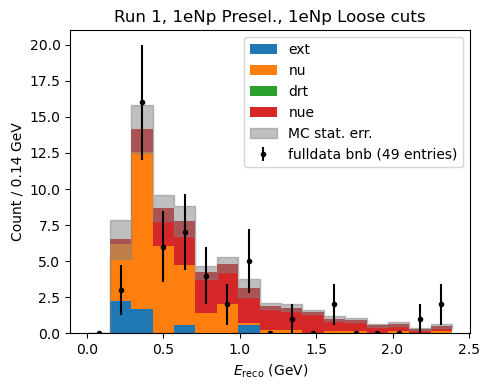

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


VARIABLE, BINS, RANGE, XTIT = "reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]"
labels = df["label"].unique()

selection = "NPL"
preselection = "NP"

presel_query = preselection_categories[preselection]["query"]
presel_title = preselection_categories[preselection]["title"]

sel_query = selection_categories[selection]["query"]
sel_title = selection_categories[selection]["title"]

if presel_query is None:
    query = sel_query
    presel_title = "No Presel."
elif sel_query is None:
    query = presel_query
    sel_title = "No Sel."
else:
    query = f"{presel_query} and {sel_query}"

fig, ax = plt.subplots(figsize=(5, 4))

bnb_filtered = df_bnb.query(query)

# Plot the beam-on data (bnb) on top as points with error bars
hist, bin_edges = np.histogram(bnb_filtered[VARIABLE], bins=BINS, range=RANGE)
hist_err = np.sqrt(hist)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.0
bin_width = (bin_edges[1:] - bin_edges[:-1])[0]
entries = np.sum(hist)
ax.errorbar(bin_centers, hist, yerr=hist_err, fmt=".", color="black", label=f"fulldata bnb ({entries:.0f} entries)")

print(f"Data bin counts: {hist}")

# Plot the MC as a stacked histogram
data = [df.query(query).loc[df.query(query)["label"] == lbl, VARIABLE] for lbl in labels]
weights = [df.query(query).loc[df.query(query)["label"] == lbl, "weights"] for lbl in labels]

ax.hist(data, bins=BINS, range=RANGE, stacked=True, label=labels, weights=weights)

# Calculate the total statistical MC error in each bin and plot it as a shaded region.
# Use the sum of squared weights in each bin as the variance. We want to sum over all
# of the stacked histograms.
hist_mc_var, _ = np.histogram(np.concatenate(data), bins=BINS, range=RANGE, weights=np.concatenate(weights) ** 2)
hist_mc_err = np.sqrt(hist_mc_var)
print(f"MC variance: {hist_mc_var}")
hist_mc_tot, _ = np.histogram(np.concatenate(data), bins=BINS, range=RANGE, weights=np.concatenate(weights))
print(f"MC bin counts: {hist_mc_tot}")
mc_err_lo = hist_mc_tot - hist_mc_err
mc_err_hi = hist_mc_tot + hist_mc_err
ax.fill_between(
    bin_edges,
    np.append(mc_err_lo, mc_err_lo[-1]),
    np.append(mc_err_hi, mc_err_hi[-1]),
    step="post",
    color="gray",
    alpha=0.5,
    label="MC stat. err.",
)

ax.legend()

ax.set_xlabel(r"$E_\mathrm{reco}$ (GeV)")
ax.set_ylabel(f"Count / {bin_width:.2f} GeV")
ax.set_title(f"Run {RUN}, {presel_title}, {sel_title}")

fig.tight_layout()

# fig.savefig(f"run{RUN}_{presel_title.replace(' ', '_').lower()}_{sel_title.replace(' ', '_').lower()}.pdf")
# old code MC total before bugfix: [ 0.     6.522 13.878  8.662  7.667  4.226  4.766  3.128  1.914  1.776
#   1.476  1.015  0.898  0.547  0.648  0.295  0.49 ]
# old code MC total after energy bugfix: [ 0.          6.52188317 14.1495637   8.92651525  7.81142247  4.25267874
#   4.77851279  3.13773905  1.91778935  1.79247478  1.47953348  1.01941426
#   0.91125443  0.54712246  0.64833618  0.29768487  0.49367103]
# old code MC total after setting trk_pid to NaN instead of 9999:
# [ 0.          6.52188317 14.1495637   8.92651525  7.81142247  4.25267874
#   4.77851279  3.13773905  1.91778935  1.79247478  1.47953348  1.01941426
#   0.91125443  0.54712246  0.64833618  0.29768487  0.49367103]